In [ ]:
import sys
# path to the src folder of the repository
sys.path.append('/Users/bhargavdesai/Desktop/test/hra-amap/src')

import trimesh
import numpy as np

from organ import Organ
from tissue import TissueBlock
from pipeline import Pipeline
from steps import normalize_rigid
from utils.conversions import to_array

from copy import deepcopy
from tqdm.auto import tqdm

##### Load a mesh as a point cloud

In [16]:
# load source and reference organs
source_atlas = Organ(path='/Users/bhargavdesai/Desktop/test/hra-amap/data/Ovary/Source/generic_ovary_updated.glb')
hra_atlas = Organ(path='../data/Ovary/Reference/VH_F_Ovary_L.glb')

##### Visualize point cloud (before)

In [17]:
# normalize (optional)
output = normalize_rigid(source=deepcopy(source_atlas.pointcloud), target=deepcopy(hra_atlas.pointcloud))
normalized_source_atlas = to_array(output.output['Source'])
normalized_target_atlas = to_array(output.output['Target'])

In [18]:
source_pc = trimesh.PointCloud(normalized_source_atlas, colors=np.tile(np.array([255, 0, 0, 1]), (len(normalized_source_atlas), 1)))
hra_pc = trimesh.PointCloud(normalized_target_atlas, colors=np.tile(np.array([0, 0, 255, 1]), (len(normalized_target_atlas), 1)))
before_scene = trimesh.Scene([source_pc, hra_pc])
# before_scene.export('/Users/bhargavdesai/Desktop/test/before.glb')
before_scene.show()

In [19]:
trimesh.Scene([source_pc]).show()

In [20]:
trimesh.Scene([hra_pc]).show()

##### Register point cloud

In [21]:
# instantiate the registration pipeline
pipeline = Pipeline(name='Base Registration', description='Base Registration', params='../configs/params.yaml')

In [22]:
# run registration
projections = pipeline.run(source=source_atlas, target=hra_atlas)

[Open3D WARNING] Too few correspondences (20) after mutual filter, fall back to original correspondences.


##### Visualize point cloud (after)

In [33]:
projected_pc = trimesh.PointCloud(projections.registration.vertices, colors=np.tile(np.array([255, 0, 0, 1]), (len(projections.registration.vertices), 1)))
hra_pc = trimesh.PointCloud(hra_atlas.vertices, colors=np.tile(np.array([0, 0, 255, 1]), (len(hra_atlas.vertices), 1)))
after_scene = trimesh.Scene([projected_pc, hra_pc])
# after_scene.export('/Users/bhargavdesai/Desktop/AMap/Figures/Figure 1/after.glb')
after_scene.show()

In [34]:
projections.registration.show()

##### Heatmap

In [35]:
from sklearn.preprocessing import minmax_scale

In [36]:
# sampled = projections.registration.simplify_quadric_decimation(10000)

In [37]:
sd = trimesh.proximity.signed_distance(hra_atlas, projections.registration.vertices)

In [38]:
# rescale
sd_scaled = minmax_scale(sd, feature_range=(-1, 1), axis=0, copy=True)

# create colors
cmap = 'jet'
colors = trimesh.visual.interpolate(sd, color_map=cmap)

# rebuild the registered organ
heatmap = trimesh.Trimesh(vertices=np.array(projections.registration.vertices), faces=np.array(projections.registration.faces), vertex_colors=colors)

In [39]:
# heatmap.export('/Users/bhargavdesai/Desktop/AMap/Figures/Figure 1/errormap.glb')
heatmap.show()

##### Histogram

In [40]:
import seaborn as sns

In [41]:
sns.set_style('darkgrid')
sns.set_theme('paper')

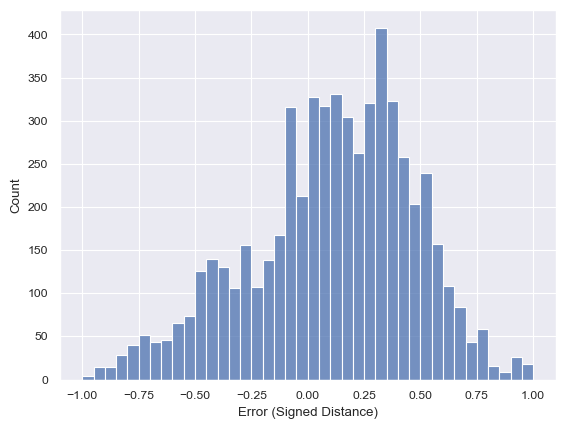

In [42]:
hist = sns.histplot(data=sd_scaled).set_xlabel('Error (Signed Distance)')
fig = hist.get_figure()
# fig.savefig("/Users/bhargavdesai/Desktop/AMap/Figures/Figure 1/hist.png") 